# Algorithm 20.1과 Algorith 20.2 기반

* UNet은 Embedding Layer를 사용하여 시간 t를 받음.
* 17 GiB 정도 사용.

In [1]:

import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch
import random
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from models.embedding_unet import EmbeddingUNet

In [2]:
batch_size = 2048
epochs = 100
seed = 42

In [3]:
np.random.seed(seed) #1
random.seed(seed) #2
torch.manual_seed(seed) #3
torch.cuda.manual_seed(seed) #4.1
torch.cuda.manual_seed_all(seed) #4.2
torch.backends.cudnn.benchmark = False #5 
torch.backends.cudnn.deterministic = True #6

# Load dataset

In [4]:

train_ds = CIFAR10(root='../../data', train=True, download=True, transform=transforms.ToTensor())
val_ds = CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


# Compute $\beta$ and $\alpha$ 

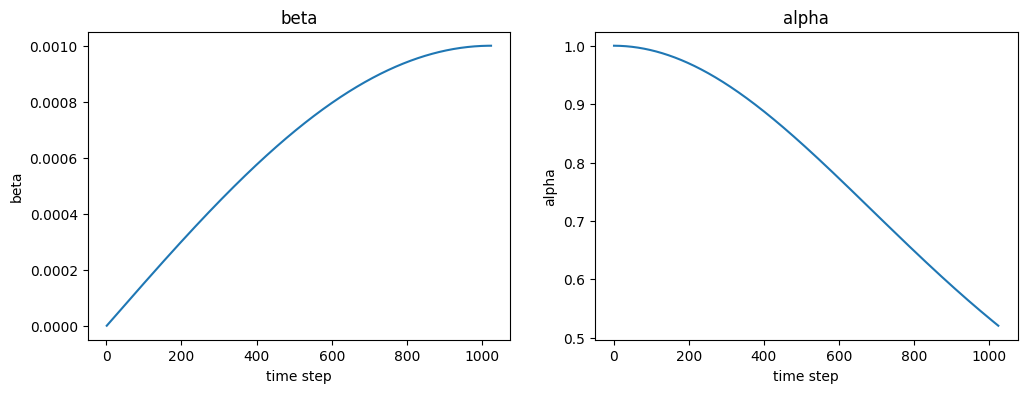

In [5]:
T = 1024    # total number of time steps
beta = [0.001 * math.sin(math.pi / 2 * (i / (T))) for i in range(1, T + 1)] #   According to the paper, beta_1 < beta_2 < ... < beta_T << 1 -> sin is suitable.
beta = np.array(beta)

alpha = np.cumprod(1 - beta) #   alpha_1 = 1 - beta_1, alpha_2 = alpha_1 * (1 - beta_2), ...
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, T+1), beta)
plt.title('beta')
plt.xlabel('time step')
plt.ylabel('beta')

plt.subplot(1, 2, 2)
plt.plot(range(1, T+1), alpha)
plt.title('alpha')
plt.xlabel('time step')
plt.ylabel('alpha')

plt.show()

# Generate latent variable $\textbf{z}_t$

In [6]:
def generate_diffusion_images(image, time_step):
    """
    Generate diffusion images from the original image.
    :param image: original image
    :param time_step: time step
    :return: diffusion image, noise
    """
    random_noise = torch.randn_like(image).to(image.device)
    return math.sqrt(alpha[time_step]) * image + math.sqrt(1 - alpha[time_step]) * random_noise, random_noise

# Define

In [7]:
model = EmbeddingUNet(input_size=32)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Train

In [8]:
for epoch in tqdm(range(epochs), desc='Epoch', position=0, leave=True):
    for (image, _) in tqdm(train_loader, desc='Step', position=1, leave=False):
        for i in range(100):
            image = image.cuda()
            optimizer.zero_grad()
            t = np.random.randint(1, T)
            image, noise = generate_diffusion_images(image, t)
            pred = model(image, torch.LongTensor([t]).cuda())
            loss = criterion(pred, noise)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Step:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Sampling

Time Step:   0%|          | 0/512 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


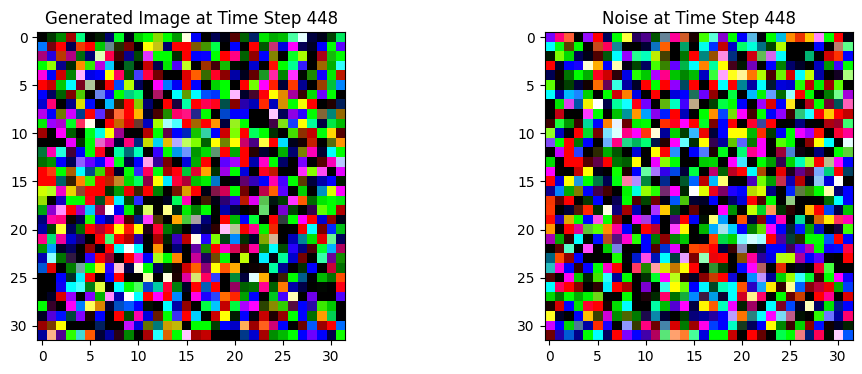

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


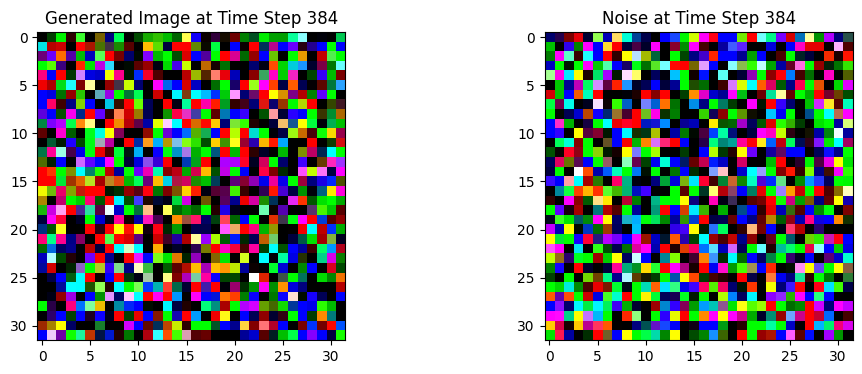

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


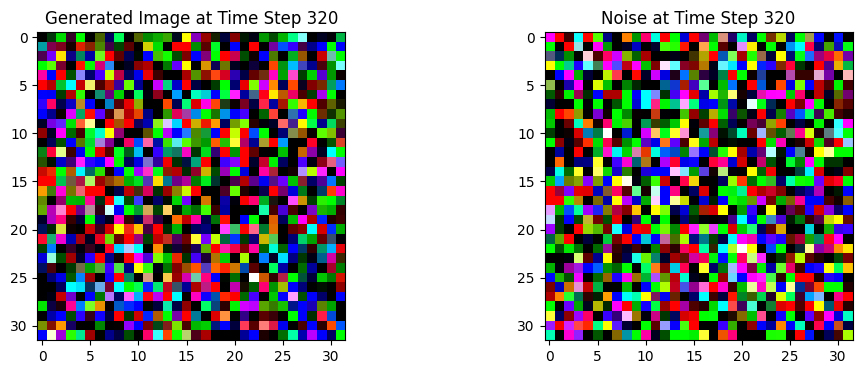

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


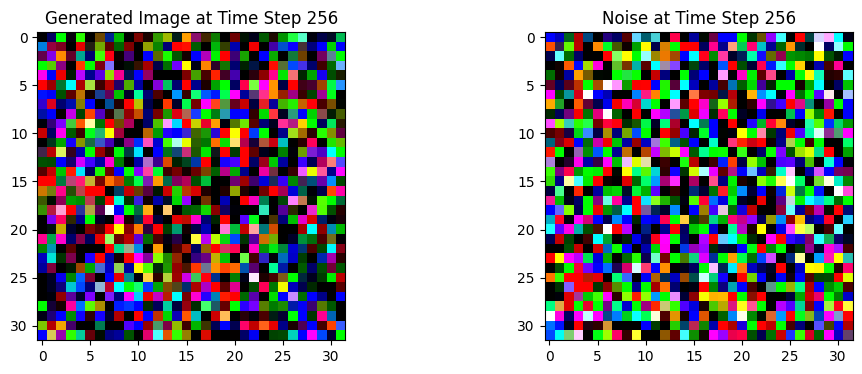

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


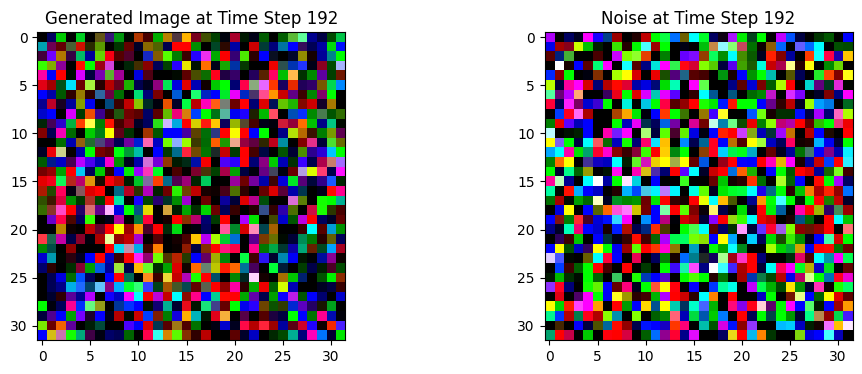

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


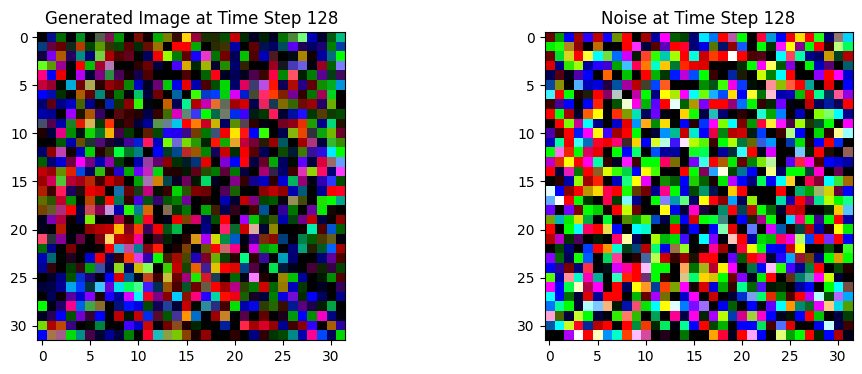

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


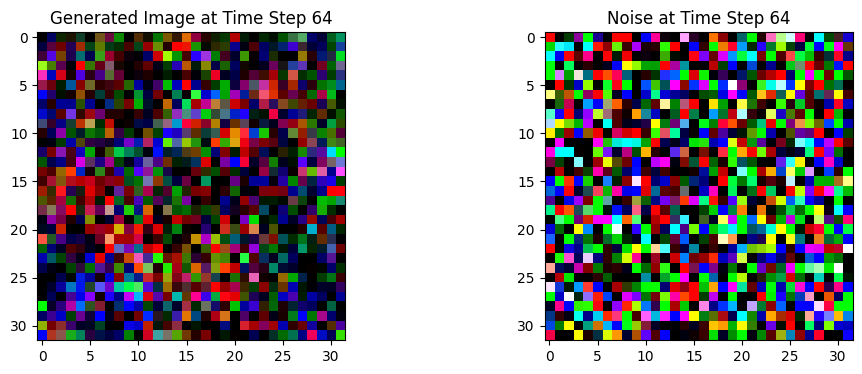

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


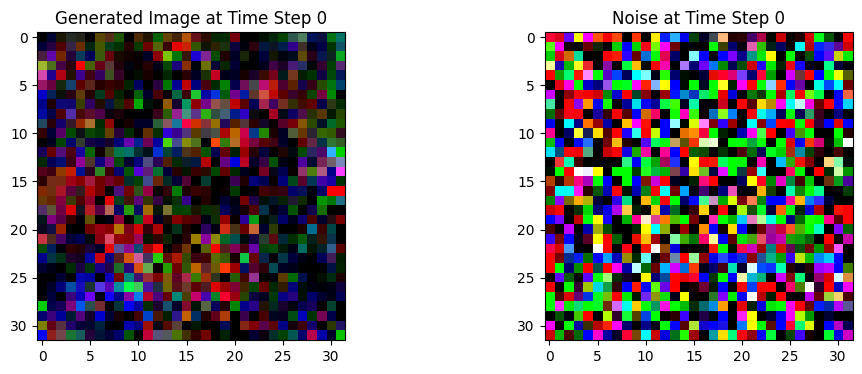

In [ ]:
z_t = torch.randn(1, 3, 32, 32).cuda()
for t in tqdm(range(T-1, -1, -1), desc='Time Step', position=0, leave=True):
    alpha_t = alpha[t]
    u = 1 / math.sqrt(1 - beta[t]) * (z_t - beta[t] / math.sqrt(1 - alpha_t) * model(z_t, torch.LongTensor([t]).cuda()))
    noise = torch.randn_like(z_t).cuda()
    z_t = u + math.sqrt(beta[t]) * noise
    if t % 64 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(z_t[0].detach().cpu().permute(1, 2, 0).numpy())
        plt.title(f'Generated Image at Time Step {t}')
        plt.subplot(1, 2, 2)
        plt.imshow(torch.randn_like(z_t[0]).detach().cpu().permute(1, 2, 0).numpy())
        plt.title(f'Noise at Time Step {t}')
        plt.show()